# FSS investigation and calibration following 2015:264 safemode

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt

from Ska.Numpy import interpolate
from Ska.engarchive import fetch_eng as fetch
from kadi import events
from Ska.Matplotlib import plot_cxctime

FSS_CAL = {'a': {'alpha': [-1.190313, 0.00007261314, -0.00001571],
                 'beta': [-1.190563, 0.00007264188, -0.00005934]},
           'b': {'alpha': [-1.190163, 0.00007266802, 0.0001902],
                 'beta': [-1.19044, 0.00007265815, -0.0001902]}}

In [3]:
# Polynominal calibration coefficients (reversed for np.polyval)
# Take from TDB PC cal curve
ALPHA_ANG_PC = [-50.01873285, 0.001739300837, 4.202023792e-08, 9.617900394e-12, -1.570367949e-15,
                1.756637723e-19, -1.118788495e-23, 3.775679639e-28, -6.421573874e-33,
                4.369576818e-38][::-1]
BETA_ANG_PC = [-50.16789839, 0.001739575081, 4.202728171e-08, 9.631457701e-12, -1.573063077e-15,
               1.760037996e-19, -1.121133178e-23, 3.784196473e-28, -6.437103687e-33,
               4.380850442e-38][::-1]

In [4]:
ODB_FSS_MISALIGN = np.zeros([4, 4, 3], dtype=np.float64)
ODB_FSS_MISALIGN[1, 1, 1] = 9.999990450374580e-01
ODB_FSS_MISALIGN[2, 1, 1] = -5.327615067743422e-07
ODB_FSS_MISALIGN[3, 1, 1] = 1.381999959551952e-03
ODB_FSS_MISALIGN[1, 2, 1] = 0.0
ODB_FSS_MISALIGN[2, 2, 1] = 9.999999256947376e-01
ODB_FSS_MISALIGN[3, 2, 1] = 3.855003493343671e-04
ODB_FSS_MISALIGN[1, 3, 1] = -1.382000062241829e-03
ODB_FSS_MISALIGN[2, 3, 1] = -3.854999811959735e-04
ODB_FSS_MISALIGN[3, 3, 1] = 9.999989707322665e-01

ODB_FSS_MISALIGN[1, 1, 2] = 9.999985515924564e-01
ODB_FSS_MISALIGN[2, 1, 2] = 2.219418563716329e-06
ODB_FSS_MISALIGN[3, 1, 2] = 1.702001193752122e-03
ODB_FSS_MISALIGN[1, 2, 2] = 0.0
ODB_FSS_MISALIGN[2, 2, 2] = 9.999991497861834e-01
ODB_FSS_MISALIGN[3, 2, 2] = -1.304004183359718e-03
ODB_FSS_MISALIGN[1, 3, 2] = -1.702002640818283e-03
ODB_FSS_MISALIGN[2, 3, 2] = 1.304002294630222e-03
ODB_FSS_MISALIGN[3, 3, 2] = 9.999977013798713e-01

In [5]:
# Generate a curve corresponding to the ground (TDB) calibration which
# gets numerically inverted to compute on-board counts from ground angle.
COUNTS = np.arange(40000)
ALPHA_ANG = np.polyval(ALPHA_ANG_PC, COUNTS)
BETA_ANG = np.polyval(BETA_ANG_PC, COUNTS)

In [6]:
def plot_compare_ground_obc_cal_curves(channel, fss='b'):
    counts = np.arange(33000)
    ang_pc = ALPHA_ANG_PC if channel == 'alpha' else BETA_ANG_PC
    ground_angle = np.polyval(ang_pc, counts)

    c0, c1, c2 = FSS_CAL[fss][channel]
    obc_angle = np.degrees(np.arctan(c0 + c1 * counts) + c2)
    plt.close(1)
    plt.figure(1)
    plt.plot(obc_angle, ground_angle - obc_angle)

In [7]:
def ground_to_obc(angle, channel, fss='b'):
    """
    Convert ``angle`` from ground telemetry (AOALPANG or AOBETANG) to output ``angle``
    (degrees) in the OBC for the given ``channel`` ('alpha' or 'beta') and ``fss``
    ('a' or 'b').
    """
    y = ALPHA_ANG if channel == 'alpha' else BETA_ANG
    f_counts = interpolate(COUNTS, y, angle)
    counts = interpolate(COUNTS, y, angle, method='nearest')
    if np.any(np.abs(f_counts - counts) > 0.01):
        raise ValueError('Bad calibration inversion')

    c0, c1, c2 = FSS_CAL[fss][channel]
    angle = np.degrees(np.arctan(c0 + c1 * counts) + c2)

    return angle

In [8]:
def get_obc_fss_angles(start='2015:001', stop='2015:004', subsample=None):
    dat = fetch.MSIDset(['aoalpang', 'aobetang', 'aoalpsun', 'aobetsun'],
                        start, stop)
    dat.interpolate(1.025, bad_union=True)

    dwells = events.dwells()
    dwells.interval_pad = -300

    bad = (dat['aoalpsun'].vals == 'NSUN') | (dat['aobetsun'].vals == 'NSUN')
    for msid in dat.keys():
        dat[msid].filter_bad(bad)
        dat[msid].select_intervals(dwells)
    dat.interpolate(times=dat['aoalpang'].times[slice(None, None, subsample)])
    dat.times = dat['aoalpang'].times

    fss = 'a' if Time(start) < Time('2013-05-10') else 'b'
    obc_alpang = ground_to_obc(dat['aoalpang'].vals, 'alpha', fss=fss)
    obc_betang = ground_to_obc(dat['aobetang'].vals, 'beta', fss=fss)

    return dat, obc_alpang, obc_betang

In [9]:
def arccos_clip(x):
    return np.arccos(x.clip(-1, 1))

In [10]:
def calc_pitch_roll_from_fss_angles(alpha, beta, fss='b'):
    """
    Adapted from Ska.engarchive.derived.pcad.DP_ROLL_FSS
    ``alpha`` and ``beta`` are FSS angles in degrees.
    Output is ``pitch`` and ``roll`` in degrees
    """
    # rotation matrix from FSS to ACA frame
    fss_align = ODB_FSS_MISALIGN[1:4, 1:4, (2 if fss == 'b' else 1)]

    # FSS's sun vector in FSS frame
    alpha = np.radians(alpha)
    beta = np.radians(beta)

    sun_fss = np.array([np.tan(beta), np.tan(alpha), -np.ones(len(alpha))])
    sun_aca = fss_align.dot(sun_fss)
    magnitude = np.sqrt((sun_aca * sun_aca).sum(axis=0))
    bads = magnitude == 0.0
    magnitude[bads] = 1.0
    sun_vec_norm = sun_aca / magnitude

    roll = np.degrees(np.arctan2(-sun_vec_norm[1, :], -sun_vec_norm[2, :]))
    pitch = np.degrees(np.arccos(sun_vec_norm[0].clip(-1, 1)))

    return pitch, roll

In [11]:
start = '2015:230'
stop = '2015:264:05:00:00'
subsample = 10

obc_dat, obc_alp, obc_bet = get_obc_fss_angles(start, stop, subsample)

In [12]:
fss = 'a' if Time(start) < Time('2013-05-10') else 'b'
obc_pitch, obc_roll = calc_pitch_roll_from_fss_angles(obc_alp, obc_bet, fss)
gnd = fetch.Msidset(['pitch', 'roll'], start, stop)
gnd.interpolate(times=obc_dat.times)

In [13]:
def plot_delta_vs_pitch_roll():
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.plot(obc_roll, (obc_pitch - gnd['pitch'].vals), '.b')
    plt.margins(0.05)
    plt.grid()
    plt.ylabel('Delta pitch (deg)')
    plt.xlabel('Pitch (deg)')
    plt.title('OBC pitch - ground pitch vs. roll')

    plt.subplot(2, 2, 2)
    plt.plot(obc_pitch, (obc_pitch - gnd['pitch'].vals), '.b')
    plt.margins(0.05)
    plt.grid()
    plt.ylabel('Delta pitch (deg)')
    plt.xlabel('Pitch (deg)')
    plt.title('OBC pitch - ground pitch vs. pitch')

    plt.subplot(2, 2, 3)
    plt.plot(obc_roll, (obc_roll - gnd['roll'].vals), '.b')
    plt.margins(0.05)
    plt.ylabel('Delta roll (deg)')
    plt.xlabel('Roll (deg)')
    plt.grid()
    plt.title('OBC roll - ground roll vs. roll')

    plt.subplot(2, 2, 4)
    plt.plot(obc_pitch, (obc_roll - gnd['roll'].vals), '.b')
    plt.margins(0.05)
    plt.ylabel('Delta roll (deg)')
    plt.xlabel('Pitch (deg)')
    plt.grid()
    plt.title('OBC roll - ground roll vs. pitch')

## Delta pitch/roll vs pitch/roll

- `OBC_pitch = OBC value of pitch from FSS (proxy to SPM)`
- `Ground_pitch = Ground value of pitch from attitude and ephemeris (proxy to MCC)`
- `Delta_pitch = OBC_pitch = Ground_pitch`

(And likewise for roll)

The four plots below show `Delta_pitch vs. roll`, `Delta_pitch vs. pitch`, `Delta_roll vs. roll`, and `Delta_roll vs. pitch`

There is a clear correlation between `Delta_roll` and `pitch`.  

Since the FSS counts-to-angle calibration for roll is independent of pitch (no axis cross-coupling), this indicates that the FSS-ACA transformation is the primary source of error.

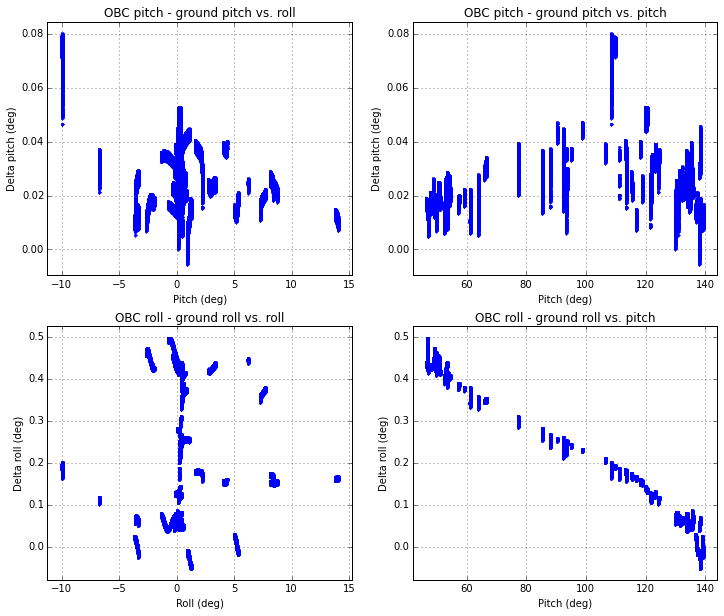

In [14]:
plot_delta_vs_pitch_roll()

## Delta pitch/roll vs time

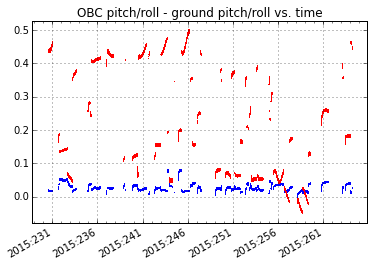

In [15]:
plot_cxctime(obc_dat.times, (obc_pitch - gnd['pitch'].vals), ',b',
             label='Pitch')
plot_cxctime(obc_dat.times, (obc_roll - gnd['roll'].vals), ',r',
             label='Roll')
plt.margins(0.05)
plt.grid()
plt.title('OBC pitch/roll - ground pitch/roll vs. time');

In [16]:
print('Final delta roll before safe mode: {:.2f} deg at {}'
      .format(obc_roll[-1] - gnd['roll'].vals[-1], 
              Time(obc_dat.times[-1], format='cxcsec').yday))

Final delta roll before safe mode: 0.44 deg at 2015:264:04:30:59.876
